In [1]:
#This performs Hierarchical modeling on a partially-observed birth-death process 0->X->0 with birth parameter A and death parameter B.
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import gamma
from scipy.stats import poisson
from scipy.stats import skellam
import scipy.integrate as integrate
import scipy.special as special

In [2]:
#import saved data
pd_subsampled_x=pd.read_csv("subsampled.csv")
x= pd_subsampled_x.values
size=np.shape(x)

In [3]:
L=3000      #length of the chain
#I=size[0]    #[0,I-1] is the observation window
#M=size[1]    #number of individuals
#initializations
M=10
I=25
A=np.zeros((L,M))               #birth parameter
B=np.zeros((L,M))               #death parameter
alpha=np.zeros((L,M))           #alpha parameter
beta=np.zeros((L,M))            #beta parameter
a_A=np.zeros(L+1)               #birth shape hyperparameter
a_B=np.zeros(L+1)               #death shape hyperparameter
b_A=np.zeros(L+1)               #birth scale hyperparameter
b_B=np.zeros(L+1)               #death scale hyperparameter
a_alpha=np.zeros(L+1)           #alpha shape hyperparameter
a_beta=np.zeros(L+1)            #beta shape hyperparameter
b_alpha=np.zeros(L+1)           #alpha scale hyperparameter
b_beta=np.zeros(L+1)            #beta scale hyperparameter
r=np.zeros((2,I-1,M))     #reaction numbers
sum_x=np.zeros(M)   
var_a_A=2                      #birth shape hyperparameter proposal variance
var_a_B=2                       #death shape hyperparameter proposal variance
var_alpha=2                       #birth shape hyperparameter proposal variance
var_beta=2                       #death shape hyperparameter proposal variance
var_a_alpha=2
var_a_beta=2
tune=200                        #reaction proposal tuning parameter
#initial conditions
A[0,:]=1
B[0,:]=1
alpha[0,:]=1
beta[0,:]=1
a_A[0]=10
b_A[0]=10 
a_B[0]=10
b_B[0]=10
a_alpha[0]=10
b_alpha[0]=10
a_beta[0]=10
b_beta[0]=10

alpha[0,:]=np.load('alpha2.npy')
beta[0,:]=np.load('beta2.npy')

In [4]:
def init_reaction(x,s):         #initialize reaction numbers           
    q=np.zeros([2,s-1])
    for i in range(s-1):
        if x[i+1]-x[i]>0:
            q[0,i]=np.floor((4/3)*(x[i+1]-x[i]))
            q[1,i]=np.floor((1/3)*(x[i+1]-x[i]))
        else:
            q[0,i]=-np.floor((1/3)*(x[i+1]-x[i]))
            q[1,i]=-np.floor((4/3)*(x[i+1]-x[i]))
    r=q.astype(int)        
    return r  

def accept_rate_react(x,r,prop,i,A,B,jump,b,alpha,beta):        #acceptance rate for reaction numbers
    lambda_prop=1+(prop[0]**2)/b
    lambda_cur=1+(r[0]**2)/b
    delay_factor=int_gammainc(alpha,beta,i)
    prop_like=np.log(poisson.pmf(prop[0],A*delay_factor)+1e-300)+np.log(poisson.pmf(prop[1],0.5*B*(x[0]+x[1]))+1e-300)+np.log(skellam.pmf(abs(jump),lambda_prop,lambda_prop)+1e-300)
    current_like=np.log(poisson.pmf(r[0],A*delay_factor)+1e-300)+np.log(poisson.pmf(r[1],0.5*B*(x[0]+x[1]))+1e-300)+np.log(skellam.pmf(abs(jump),lambda_cur,lambda_cur)+1e-300)
    rate=np.minimum(1,np.exp(prop_like-current_like))
    return rate

def a_lik(A,a,b):           #shape hyperparameter likelihood function 
    sum1=0
    M=len(A)
    for s in range(M):
        sum1+=np.log(A[s])
    sum1*=(a-1)
    q=-M*np.log(math.gamma(a))+M*a*np.log(b)+sum1
    return q

def alpha_lik(alpha,beta,A,a,b,I,r):      #alpha loglikelihood
    sum_int_gammainc=0
    sum_log_gammainc=0
    for jj in range(I-1):
        kappa=int_gammainc(alpha,beta,jj)
        log_kappa=r[jj]*np.log(kappa+1e-300)
        sum_int_gammainc+=kappa
        sum_log_gammainc+=log_kappa
    q=sum_log_gammainc-(A*sum_int_gammainc)+((a-1)*np.log(alpha))-alpha*b    
    return q

def beta_lik(alpha,beta,A,a,b,I,r):    #beta loglikelihood
    sum_int_gammainc=0
    sum_log_gammainc=0
    for jj in range(I-1):
        kappa=int_gammainc(alpha,beta,jj)
        log_kappa=r[jj]*np.log(kappa+1e-300)
        sum_int_gammainc+=kappa
        sum_log_gammainc+=log_kappa
    q=sum_log_gammainc-(A*sum_int_gammainc)+((a-1)*np.log(beta))-beta*b    
    return q

def int_gammainc(alpha,beta,m):
    k,s=integrate.quad(lambda x: gamma.cdf(x,alpha,beta**(-1)),m,m+1)
    return k

In [5]:
#initialize number of reactions
for s in range(M):
    r[:,:,s]= init_reaction(x[:,s],I)
    sum_x[s]=x[0,s]+x[I-1,s]
    for j in range(I-2):
        sum_x[s]+=2*x[j+1,s]
    sum_x[s]=0.5*sum_x[s]    
#r=np.load('react2.npy') 
#print(r)

In [6]:
#perform sampling       
for i in range(L-1): 
    for s in range(M):
        #gamma incomplete function values
        sum_int_gammainc=0
        for j in range(I-1):
            sum_int_gammainc+=int_gammainc(alpha[i,s],beta[i,s],j)
            
        #sample parameters
        A[i+1,s]=np.random.gamma(np.sum(r[0,:,s])+a_A[i],(sum_int_gammainc+b_A[i])**(-1))
        B[i+1,s]=np.random.gamma(np.sum(r[1,:,s])+a_B[i],(sum_x[s]+b_B[i])**(-1))
        #print('pass A,B')
        
        #update parameter alpha
        alpha_prop=-1
        while alpha_prop<0:
            alpha_prop=alpha[i,s]+np.random.normal(0,var_alpha)
        a=alpha_lik(alpha_prop,beta[i,s],A[i+1,s],a_alpha[i],b_alpha[i],I,r[0,:,s]) 
        b=alpha_lik(alpha[i,s],beta[i,s],A[i+1,s],a_alpha[i],b_alpha[i],I,r[0,:,s])
        rate=np.minimum(1,np.exp(a-b))
        #print(rate)
        if np.random.uniform(0,1,1)<rate:    
            alpha[i+1,s]=alpha_prop
        else:
            alpha[i+1,s]=alpha[i,s]
        #print('pass alpha')
        
        #update parameter beta
        beta_prop=-1
        while beta_prop<0:
            beta_prop=beta[i,s]+np.random.normal(0,var_beta)
        a=beta_lik(alpha[i+1,s],beta_prop,A[i+1,s],a_beta[i],b_beta[i],I,r[0,:,s]) 
        b=beta_lik(alpha[i+1,s],beta[i,s],A[i+1,s],a_beta[i],b_beta[i],I,r[0,:,s])
        rate=np.minimum(1,np.exp(a-b))
        #print(rate)
        if np.random.uniform(0,1,1)<rate:    
            beta[i+1,s]=beta_prop
        else:
            beta[i+1,s]=beta[i,s]
        #print('pass beta')
        
        #update reaction numbers
        for j in range(I-1):
            r_vprop=np.array([-1,-1])
            lamb=1+(r[0,j,s]**2)/tune                 #tuning parameter suggested in Boy's paper 
            while r_vprop[0]<0 or r_vprop[1]<0:
                jump=np.random.poisson(lamb)-np.random.poisson(lamb)
                r_prop=r[0,j,s]+jump
                r_vprop=[r_prop, r_prop-(x[j+1,s]-x[j,s])]    
            rate=accept_rate_react([x[j,s],x[j+1,s]],r[:,j,s],r_vprop,j,A[i+1,s],B[i+1,s],jump,tune,alpha[i+1,s],beta[i+1,s]) 
            if np.random.uniform(0,1,1)<rate:
                r[:,j,s]=r_vprop    
        #print('pass r')   
        
    #sample hyperparameters a_A and a_B
    a_Aprop=-1
    while a_Aprop<0:
        a_Aprop=a_A[i]+np.random.normal(0,var_a_A)
    a=a_lik(A[i+1,:],a_Aprop,b_A[i]) 
    b=a_lik(A[i+1,:],a_A[i],b_A[i])
    rate=np.minimum(1,np.exp(a-b))
    if np.random.uniform(0,1,1)<rate:    
        a_A[i+1]=a_Aprop
    else:
        a_A[i+1]=a_A[i]
        
    a_Bprop=-1
    while a_Bprop<0:
        a_Bprop=a_B[i]+np.random.normal(0,var_a_B)
    a=a_lik(B[i+1,:],a_Bprop,b_B[i]) 
    b=a_lik(B[i+1,:],a_B[i],b_B[i])
    rate=np.minimum(1,np.exp(a-b))
    if np.random.uniform(0,1,1)<rate:    
        a_B[i+1]=a_Bprop
    else:
        a_B[i+1]=a_B[i]    
    #print('pass a_A,B')
    
    #sample hyperparameters a_alpha and a_beta
    a_alphaprop=-1
    while a_alphaprop<0:
        a_alphaprop=a_alpha[i]+np.random.normal(0,var_a_alpha)
    a=a_lik(alpha[i+1,:],a_alphaprop,b_alpha[i]) 
    b=a_lik(alpha[i+1,:],a_alpha[i],b_alpha[i])
    rate=np.minimum(1,np.exp(a-b))
    if np.random.uniform(0,1,1)<rate:    
        a_alpha[i+1]=a_alphaprop
    else:
        a_alpha[i+1]=a_alpha[i]
        
    a_betaprop=-1
    while a_betaprop<0:
        a_betaprop=a_beta[i]+np.random.normal(0,var_a_beta)
    a=a_lik(beta[i+1,:],a_betaprop,b_beta[i]) 
    b=a_lik(beta[i+1,:],a_beta[i],b_beta[i])
    rate=np.minimum(1,np.exp(a-b))
    if np.random.uniform(0,1,1)<rate:    
        a_beta[i+1]=a_betaprop
    else:
        a_beta[i+1]=a_beta[i]
    #print('pass a_alpha,beta')
    
    #sample hyperparameters b_A, b_B, b_alpha, b_beta
    sum1=np.sum(A[i+1,:])
    sum2=np.sum(B[i+1,:])
    sum3=np.sum(alpha[i+1,:])
    sum4=np.sum(beta[i+1,:])
    b_A[i+1]=np.random.gamma(M*a_A[i+1],sum1**(-1))
    b_B[i+1]=np.random.gamma(M*a_B[i+1],sum2**(-1))
    b_alpha[i+1]=np.random.gamma(M*a_alpha[i+1],sum3**(-1))
    b_beta[i+1]=np.random.gamma(M*a_beta[i+1],sum4**(-1))
    #print('pass b_A,B,alpha,beta')
        
    if i%10 == 0:  
        print(i+1,'birth',a_A[i+1],b_A[i+1],'death',a_B[i+1],b_B[i+1]) 
        print(i+1,'alpha',a_alpha[i+1],b_alpha[i+1],'beta',a_beta[i+1],b_beta[i+1]) 
        print("%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%")
    elif i == L-2:
        print(i+1,'birth',a_A[i+1],b_A[i+1],'death',a_B[i+1],b_B[i+1]) 
        print(i+1,'alpha',a_alpha[i+1],b_alpha[i+1],'beta',a_beta[i+1],b_beta[i+1]) 
        print("%%%%%%%%%%%%%%%%%done%%%%%%%%%%%%%%%%")

1 birth 10.0 4.15630386699766 death 9.095752313785123 95.95259095060125
1 alpha 9.61270847915488 8.007702868498065 beta 10.0 11.102364106910684
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
11 birth 9.305973079627854 2.5600924250694237 death 5.776717962439711 74.47549322436055
11 alpha 9.016047652269902 4.746696945199139 beta 11.225145097757357 14.883368810382
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
21 birth 16.45629485219214 4.25413465466009 death 3.3440945221092457 28.159146077960695
21 alpha 9.212403335058507 4.433052562612048 beta 9.639307271610784 10.398657929155474
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
31 birth 13.917267453965588 2.946626335804542 death 3.9199424098177658 36.798693763450295
31 alpha 8.750224522785924 2.767988639285011 beta 11.485237267490367 11.939365442774958
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
41 birth 16.81121878514519 3.5089633016755593 death 2.9735882751054543 19.26450753641574
41 alpha 8.864005076875946 2.1472404073091433 beta 6.861109777047699 8.75913769298027
%%%

391 birth 10.307020713531147 1.8469757379561695 death 3.676607919067558 20.392435525706702
391 alpha 12.80517311264626 2.5360481701433493 beta 19.239605839928842 4.725095659496851
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
401 birth 9.360497099162604 1.3548327031572132 death 3.2338667669718006 23.21997414596424
401 alpha 7.961084232984255 1.5968684397749169 beta 18.438583232763868 4.435389844219674
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
411 birth 6.785333665697695 1.043555248637 death 3.95658706876538 22.750489700398035
411 alpha 7.051545094789055 1.4368771220356709 beta 18.841688000787247 5.255550076069672
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
421 birth 8.02636325741183 1.701833944645725 death 5.347817214283289 34.95753681382976
421 alpha 6.854450123667402 1.3370525638327446 beta 13.852645423583624 3.54828137662335
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
431 birth 6.089294784040597 0.9573709513142488 death 4.7947970343223005 16.62698968120792
431 alpha 5.653325948448687 1.2038507874579711 bet

771 birth 8.605188454062965 1.2912574651980406 death 6.480495822129875 30.677664126372903
771 alpha 5.257485617276854 1.0168236263281285 beta 23.32508981125971 5.613233304809573
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
781 birth 7.876438125059022 1.017797358860503 death 8.458835323479336 45.84026160412247
781 alpha 3.9785386933196656 0.6504777247306492 beta 21.649041159581202 5.090728664374084
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
791 birth 7.070505475288401 0.9880808330091848 death 6.8642792869906115 28.700432768369872
791 alpha 3.1206144746753046 0.464212301806801 beta 19.468938739492778 2.8173454626490004
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
801 birth 6.124980046624954 1.0716922883110573 death 7.601170149789947 41.625162629747194
801 alpha 4.171545616189281 0.868143030910248 beta 13.04264596111933 2.12694369459918
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
811 birth 5.974842221501534 1.0575053087361383 death 7.956669685034929 43.99790459719688
811 alpha 3.048910157034057 0.4306295833472872

1151 birth 18.872003343150183 3.1219209275913724 death 3.5434374904598918 18.06669896386701
1151 alpha 5.713478682567837 0.9966242370322194 beta 19.53264356734861 1.2752237666120565
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1161 birth 18.84258923023031 2.7864037902902914 death 3.486193699828682 18.068641229328044
1161 alpha 5.713478682567837 0.8794520593875518 beta 18.538114780738738 1.0893726946926965
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1171 birth 16.971001277746264 2.9083129594752006 death 3.4125957378988456 14.58402582481745
1171 alpha 5.0525478713288114 0.8628512758626111 beta 14.290449004294112 0.9090783492771202
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1181 birth 15.9374588693936 2.546005019195299 death 2.9711259770089313 17.85636267421473
1181 alpha 3.2183172848431387 0.6235107820017977 beta 13.415646192042088 0.8723801254220381
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1191 birth 14.782112051723796 2.355864738272544 death 3.4064274679541406 19.59772534459082
1191 alpha 2.573598310921384

1531 birth 37.57923997557694 6.546076186729282 death 1.126991072084668 4.389352497867596
1531 alpha 4.6721905736208145 1.0408973869579021 beta 60.07468502142261 5.033799218611892
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1541 birth 42.58102609216606 6.74655819533817 death 1.04530602856956 5.050059382047843
1541 alpha 4.534514240296653 0.9501950072216856 beta 59.71967239442193 5.2747494053597865
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1551 birth 42.32798055027791 7.5565622256007545 death 1.04530602856956 7.555410282232875
1551 alpha 5.106974212062054 1.1295688300258087 beta 65.91530334626164 5.144174983813247
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1561 birth 42.96573494389317 7.200776495940255 death 1.910359196890329 12.738401239882043
1561 alpha 4.246066415003351 0.7200426764405745 beta 63.80825917642019 4.618200553338772
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1571 birth 43.83060901361942 7.002721767795638 death 1.226213895068238 7.011256335027506
1571 alpha 4.265901262471375 0.927126699269830

1911 birth 42.30141984799806 7.15333300301933 death 3.420351906815726 17.92073799382295
1911 alpha 4.691932696332997 0.9089365350584128 beta 96.58458630828879 12.028941363573123
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1921 birth 50.584360319406066 8.939248665130066 death 1.1422789628623664 8.859689009986763
1921 alpha 5.479418420477056 1.012654503493663 beta 99.90647518601568 13.70072050175183
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1931 birth 40.523830332483385 6.437773765070823 death 1.4212004795735012 5.959874852655552
1931 alpha 5.4240283604714135 0.7406335947234703 beta 98.51259919341176 14.712453095997127
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1941 birth 36.33520246685709 6.695304516320555 death 3.4250518969841495 19.44855112833766
1941 alpha 9.437338928402358 1.7544612323269215 beta 93.08867912358167 15.372289520876118
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
1951 birth 35.680340101726664 6.6576633588745135 death 2.666489549767065 13.799870366181516
1951 alpha 8.060913645392397 1.536239

2291 birth 52.03225505654924 7.375103360708723 death 2.568198838441333 12.603639340941587
2291 alpha 14.01583196134484 2.3334111016134846 beta 53.87993414766557 5.704073364398152
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
2301 birth 45.87803647310324 6.166138185150747 death 3.9369551239155745 17.924620025244955
2301 alpha 10.383075515797461 1.7556426783778152 beta 52.531396126077674 5.121338530237214
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
2311 birth 40.293316567558875 6.540414216673931 death 3.560721481339458 16.98157187325807
2311 alpha 5.880295079508651 1.0108143558697824 beta 55.6483933933054 5.634014994627223
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
2321 birth 38.120949408250745 5.99021604456274 death 5.322740222592055 25.96224598518229
2321 alpha 4.378578935098109 0.8292871448148449 beta 65.2927111251781 7.7010433814919645
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
2331 birth 35.25167758753528 5.373485953370022 death 3.795966578097907 15.560439191775844
2331 alpha 2.4508573643334635 0.365219243

2671 birth 30.940890427201648 5.288060423441646 death 2.847804646630361 16.482175200920846
2671 alpha 3.087111608375886 0.6243477782506791 beta 70.81794885616193 4.797815692188954
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
2681 birth 31.348926788878337 5.543150025437503 death 2.742575660845703 12.825030440713155
2681 alpha 3.7442203035379666 0.9935607354351866 beta 64.7489949871882 4.781274072660657
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
2691 birth 34.79905656156379 5.826511698255431 death 3.156022972489617 14.150354719818768
2691 alpha 2.6467490545027452 0.47104483358918414 beta 65.9354155469035 4.818662390329691
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
2701 birth 42.992561105795325 8.175932705824508 death 2.002832578132449 11.961259682876776
2701 alpha 3.7098377511847604 0.5373290664211592 beta 61.53778670021699 4.02611518787647
%%%%%%%%%%%%%%%%%next%%%%%%%%%%%%%%%%
2711 birth 39.044452858394976 6.756684028938559 death 2.7528098983577953 13.240678791451167
2711 alpha 3.4528222673722095 0.6327

In [7]:
#save the simulated values into .csv files
np.save('alpha2.npy',alpha[i-1,:])
np.save('beta2.npy',beta[i-1,:])
np.save('react2.npy',r) 
columns=' '
np.savetxt("A21.csv", A, delimiter=",",header=columns)
np.savetxt("B21.csv", B, delimiter=",",header=columns)
np.savetxt("alpha21.csv", alpha, delimiter=",",header=columns)
np.savetxt("beta21.csv", beta, delimiter=",",header=columns)
np.savetxt("a_A21.csv", a_A, delimiter=",",header=columns)
np.savetxt("b_A21.csv", b_A, delimiter=",",header=columns)
np.savetxt("a_B21.csv", a_B, delimiter=",",header=columns)
np.savetxt("b_B21.csv", b_B, delimiter=",",header=columns)
np.savetxt("a_alpha21.csv", a_alpha, delimiter=",",header=columns)
np.savetxt("b_alpha21.csv", b_alpha, delimiter=",",header=columns)
np.savetxt("a_beta21.csv", a_beta, delimiter=",",header=columns)
np.savetxt("b_beta21.csv", b_beta, delimiter=",",header=columns)

In [ ]:
np.save('r.npy',r)

In [ ]:
np.save('r.npy',r)
np.save('A.npy',A)
np.save('B.npy',B)
np.save('alpha.npy',alpha)
np.save('beta.npy',beta)
np.save('a_A.npy',a_A)
np.save('a_B.npy',a_B)
np.save('b_A.npy',b_A)
np.save('b_B.npy',b_B)
np.save('a_alpha.npy',a_alpha)
np.save('a_beta.npy',a_beta)
np.save('b_alpha.npy',b_alpha)
np.save('b_beta.npy',b_beta)

In [ ]:
r=np.load('r.npy')
A=np.load('A.npy')
B=np.load('B.npy')
alpha=np.load('alpha.npy')
beta=np.load('beta.npy')
a_A=np.load('a_A.npy')
a_B=np.load('a_B.npy')
b_A=np.load('b_A.npy')
b_B=np.load('b_B.npy')
a_alpha=np.load('a_alpha.npy')
a_beta=np.load('a_beta.npy')
b_alpha=np.load('b_alpha.npy')
b_beta=np.load('b_beta.npy')

In [ ]:
A=A[:i,:]
B=B[:i,:]
alpha=alpha[:i,:]
beta=beta[:i,:]
a_A=a_A[:i]
a_B=a_B[:i]
b_A=b_A[:i]
b_B=b_B[:i]
a_alpha=a_alpha[:i]
a_beta=a_beta[:i]
b_alpha=b_alpha[:i]
b_beta=b_beta[:i]

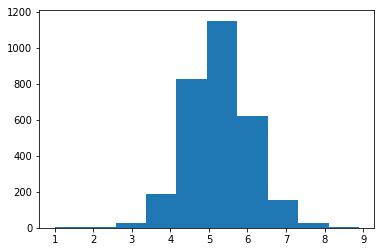

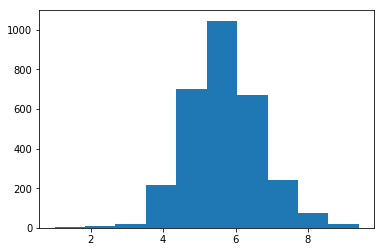

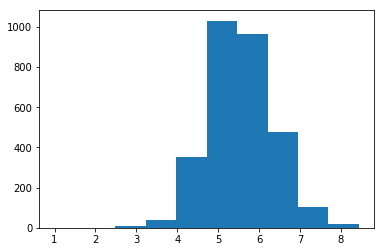

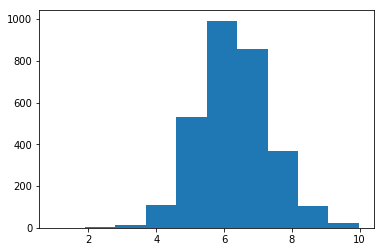

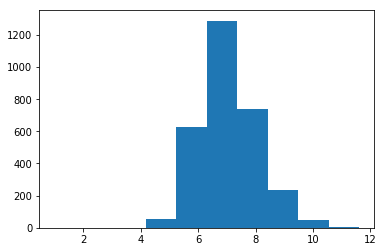

In [8]:
plt.hist(A[:,1])
plt.show()
plt.hist(A[:,2])
plt.show()
plt.hist(A[:,3])
plt.show()
plt.hist(A[:,4])
plt.show()
plt.hist(A[:,5])
plt.show()

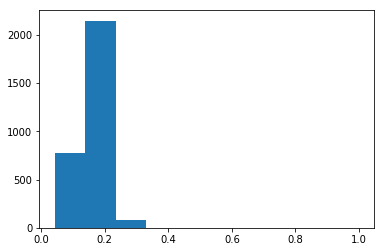

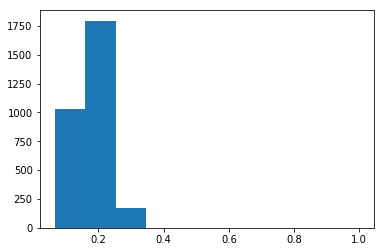

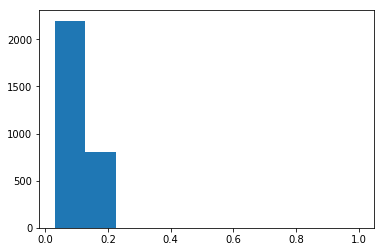

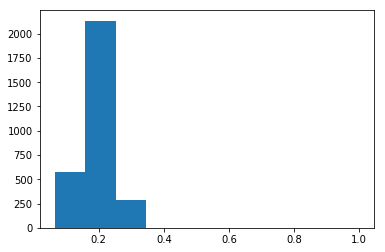

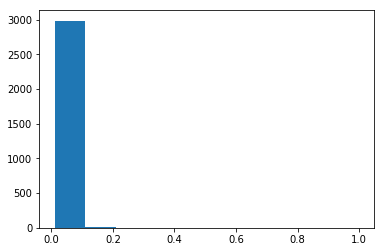

In [9]:
plt.hist(B[:,1])
plt.show()
plt.hist(B[:,2])
plt.show()
plt.hist(B[:,3])
plt.show()
plt.hist(B[:,4])
plt.show()
plt.hist(B[:,5])
plt.show()

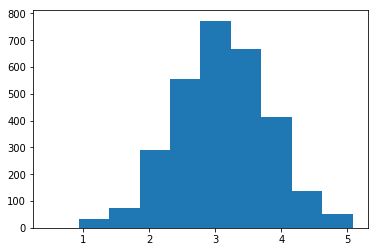

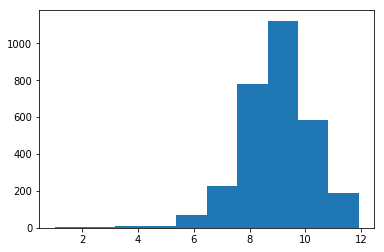

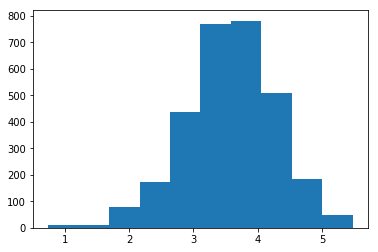

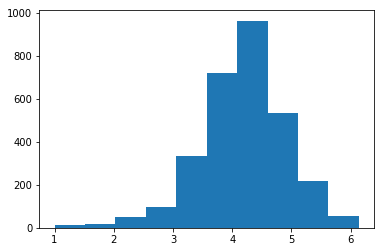

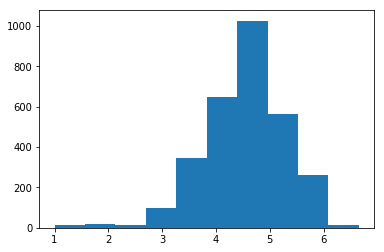

In [10]:
plt.hist(alpha[:,1])
plt.show()
plt.hist(alpha[:,2])
plt.show()
plt.hist(alpha[:,3])
plt.show()
plt.hist(alpha[:,4])
plt.show()
plt.hist(alpha[:,5])
plt.show()

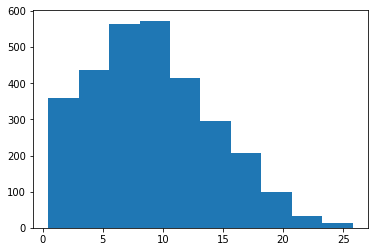

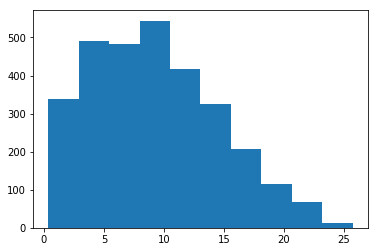

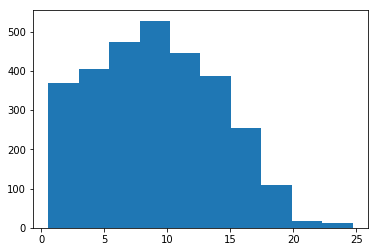

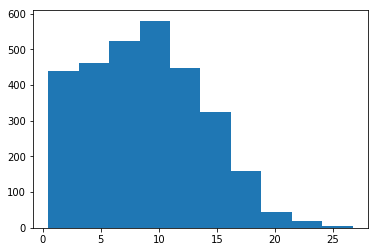

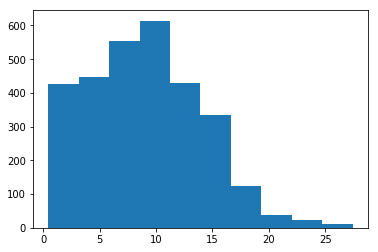

In [11]:
plt.hist(beta[:,1])
plt.show()
plt.hist(beta[:,2])
plt.show()
plt.hist(beta[:,3])
plt.show()
plt.hist(beta[:,4])
plt.show()
plt.hist(beta[:,5])
plt.show()

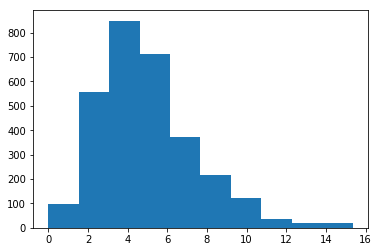

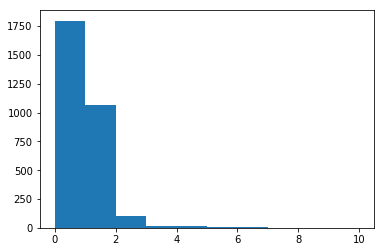

In [12]:
plt.hist(a_alpha)
plt.show()
plt.hist(b_alpha)
plt.show()

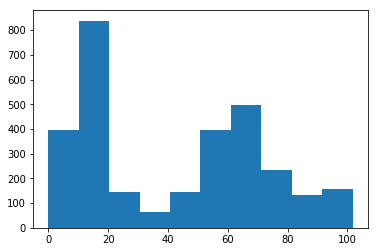

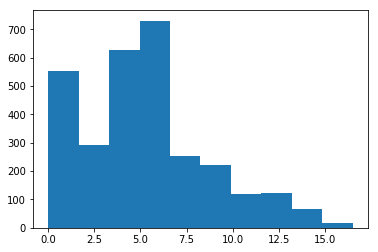

In [13]:
plt.hist(a_beta)
plt.show()
plt.hist(b_beta)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(a_A,lags=len(a_A)-1)
plot_acf(b_A,lags=len(b_A)-1)
plt.show

In [ ]:
r[:,:,6]

In [ ]:
tA=np.load('trueA.npy')

In [ ]:
A[i+1,:]

In [ ]:
B[i+1,:]

In [ ]:
a_A[i+1]

In [ ]:
b_A[i+1]

In [ ]:
import numpy as np
np.log(1e-300)

In [ ]:
B[:,4]